In [374]:
import numpy as np
from numpy import ma
from netCDF4 import Dataset
import matplotlib.pyplot as plt

exec(open("/users/jbellier/Documents/GitHub/GSDM/Functions/Various_functions.py").read())
exec(open("/users/jbellier/Documents/GitHub/GSDM/Functions/Calibration_functions.py").read())
exec(open("/users/jbellier/Documents/GitHub/GSDM/Functions/GSV_functions.py").read())
exec(open("/users/jbellier/Documents/GitHub/GSDM/Functions/GSDM_functions.py").read())
exec(open("/users/jbellier/Documents/GitHub/GSDM/Functions/Function_constrNMPy.py").read())
exec(open("/users/jbellier/Documents/GitHub/GSDM/Functions/Functions_dates.py").read())
exec(open("/users/jbellier/Documents/GitHub/GSDM/Functions/ParameterSpatialization_functions.py").read())

In the above scripts that contains all the functions, additional modules may be loaded:

In [375]:
from scipy.interpolate import interp1d
import math
from datetime import datetime, timedelta
import pandas as pd
from numba import njit
import scipy.optimize as sciopt
from numpy.random import lognormal, randint

The function `ParameterSpatialization_functions.py` requires some more uncommon modules:

In [376]:
from scipy.ndimage import label
from scipy.spatial import Delaunay
from skimage.draw import line as skimage_line
import networkx
import warnings

However it is an experimental function, which is only used at the very end of this notebook, so they are not mandatory for running 95% of it.

# 1. Using the GSDM function

The GSDM is a stochastic method that involves random processes in several functions. However, for each of these functions it is possible to feed a random seed, so that the ouputs can be reproduced exactly. In this Notebook, let's use:

In [377]:
seed = 123    # (it can be any number, though)

## 1.1 Basic example
We first load a dataset comprising 40 fine-scale precipitation analyses, but over a smaller area delineated by:

In [378]:
lb_lat, ub_lat, lb_lon, ub_lon = 38., 42., -124.7, -120.9

In [379]:
nc = Dataset('Data/sample_data.nc')
id_lat_fine = np.logical_and(nc.variables['lat_fine'][:] >= lb_lat, nc.variables['lat_fine'][:] <= ub_lat)
id_lon_fine = np.logical_and(nc.variables['lon_fine'][:] >= lb_lon, nc.variables['lon_fine'][:] <= ub_lon)
lat_fine = nc.variables['lat_fine'][:][id_lat_fine]
lon_fine = nc.variables['lon_fine'][:][id_lon_fine]
N_fineFields = nc.variables['fine_fields'][:][:,id_lat_fine,:][:,:,id_lon_fine].copy()   
##   (by making a copy, we make sure the array is C-contiguous, to avoid Numba functions to bug later)
mask_fine = N_fineFields[0,:,:].mask
yyyymmddhh_end6h = nc.variables['yyyymmddhh_end6h'][:]
date_end6h = yyyymmddhh_to_date(yyyymmddhh_end6h)
nc.close()

N, nya, nxa = N_fineFields.shape

In this example, we will first aggregate these fine-scale analyses to a coarser grid, and downscale them back to the fine-scale so that they can be compared to the original analyses. 



In [380]:
nc = Dataset('Data/sample_data.nc')
id_lat_coarse = np.logical_and(nc.variables['lat_coarse'][:] >= lb_lat, nc.variables['lat_coarse'][:] <= ub_lat)
id_lon_coarse = np.logical_and(nc.variables['lon_coarse'][:] >= lb_lon, nc.variables['lon_coarse'][:] <= ub_lon)
lat_coarse = nc.variables['lat_coarse'][:][id_lat_coarse]
lon_coarse = nc.variables['lon_coarse'][:][id_lon_coarse]
nc.close()

N_coarseFields = aggregate_fine2coarse(Nfine_fields=N_fineFields, 
                                       latLon_analFcst=[lat_fine, lon_fine, lat_coarse, lon_coarse],
                                       mask_field=mask_fine)
N, nyc, nxc = N_coarseFields.shape
mask_coarse = N_coarseFields[0,:,:].mask

Before downnscaling, we prepare an arrray called `closest_cell`, which is used in various functions and gives for each fine-scale pixel the index of the coarse-scale pixel it belongs to. In other words, `closest_cell` specifies the "match" between the fine-scale and the coarse-scale grids.

In [381]:
closest_cell = get_closest_cell_mat(lon_coarse, lat_coarse, lon_fine, lat_fine)

Also, we define a value for the only "fixed" parameter of the GSDM, the number `N_iter` of Gibbs sampling iterations, and we put in a dictionnary `par_GSDM` (a common practice used in several functions later)

In [382]:
par_GSDM = dict(N_iter=10)

Let's now downscale these coarse-scale fields stored in `N_coarseFields`. For now we select the simple E30S20 model, which does not use any meteorological predictors or the orographic enhancement, and provide the values for the free parameters:

In [383]:
modelE = 'E30'
modelS = 'S20'
parE = np.array([1.1, 0.05, -0.1])
parS = np.array([0.13, 0.07])

- `modelE` must be selected among: `'E10'`,`'E30'`,`'E21'`,`'E32'`,`'E20o'`,`'E40o'`,`'E31o'`,`'E42o'`.

- `modelS` must be selected among: `'S10'`,`'S20'`,`'S21'`,`'S31'`.

For both models, the first digit indicates the number of free parameters, while the secod digit indicates the number of meteorological predictor used. For `modelE`, the character `'o'` at the end indicates that the orographic precipitation enhancement is activated. The combination of a given `modelE` and `modelS` is called a GSDM variant.

Downscaling with E30S20:

In [384]:
N_downFields = ma.array(np.zeros_like(N_fineFields), mask=True)
for n in range(N):
    N_downFields[n,:,:] = GSDM_njit(modelE, modelS, parE, parS,
                                    coarse_field=ma.filled(N_coarseFields[n,:,:], fill_value=0.), 
                                    closest_cell=closest_cell, 
                                    ASP=np.zeros((nya,nxa)), 
                                    ADP=np.zeros((nya,nxa)), 
                                    SVP=np.zeros((nya,nxa)), 
                                    relDiff_C_av=np.zeros((nya,nxa)), 
                                    mask_field=mask_fine, 
                                    rs_pred3_spVar='no_pred3', 
                                    N_iter=par_GSDM['N_iter'], 
                                    seed=seed*n)

## The output of GSDM_njit() is not masked, so the final step is to apply the fine-scale mask:
N_downFields.mask = mask_fine[None,:,:]

Remarks:
- `parE` and `parS` must be arrays and not lists, as Numba rejects list in arguments.
- `coarse_field` can't be a masked array (per Numba requirements), so we must fill with zeros.
- We here use the model E30S20, so the the arguments `ASP`, `ADP` and `SVP`, which are the anisotropy strength predictor (ASP),  anisotropy direction predictor (ASP) and spatial variability predictor (SVP) fields, can be set to any value. We must still input arrays with the correct shape though, as Numba doesn't allow arguments to be `None`.
- Same for `relDiff_C_av`, which concerns the precipitation enhanecement module (see later), which is not used here. Must also be an array with correct shape.
- `rs_pred3_spVar` must be set to `'no_pred3'` if no SVP is used (see also later).
- We here set `seed=seed*n`, but it could actually be anything (e.g., `seed+n`). The idea is just that the seed is different for each `n`, otherwise the GSDM applies for all dates the same random sampling probabilities for the same pixels.

Finally, let's plot the fields for the first date (`n=0`):

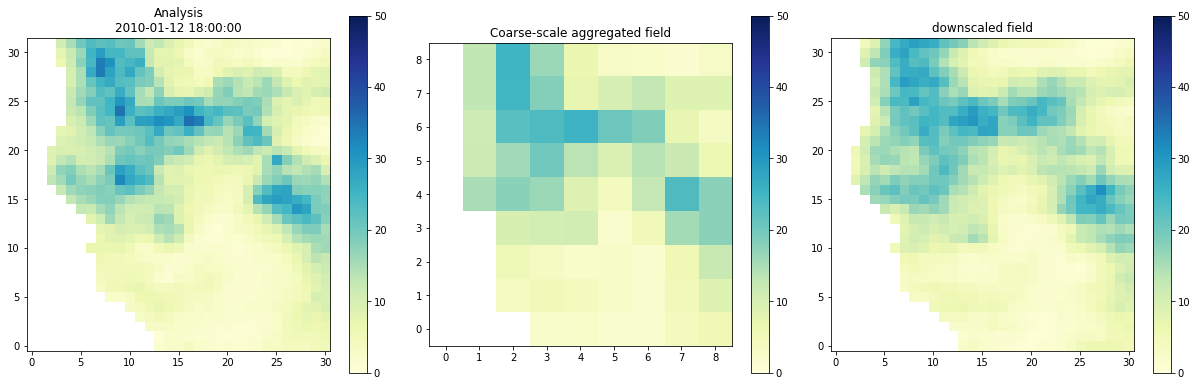

In [385]:
n = 0
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(17,5.4))
ims = ax1.imshow(N_fineFields[n,:,:], origin='lower', cmap='YlGnBu', vmin=0, vmax=50)
cbar = plt.colorbar(ims, ax=ax1)
ax1.set_title('Analysis\n'+str(date_end6h[n]))
ims = ax2.imshow(N_coarseFields[n,:,:], origin='lower', cmap='YlGnBu', vmin=0, vmax=50)
cbar = plt.colorbar(ims, ax=ax2)
ax2.set_title('Coarse-scale aggregated field')
ims = ax3.imshow(N_downFields[n,:,:], origin='lower', cmap='YlGnBu', vmin=0, vmax=50)
cbar = plt.colorbar(ims, ax=ax3)
ax3.set_title('downscaled field')
plt.tight_layout()
plt.show()

## 1.2 Use of meteorological predictors

Let's load the predictor Wind speed 700 hPa, Wind direction 700 hPa, and CAPE, to drive respectively the anisotropy strength, the anisotropy direction, and the spatial variability of the downscaled fields:

In [386]:
nc = Dataset('Data/sample_data.nc')
windSpeed_700 = nc.variables['windSpeed_700'][:][:,id_lat_coarse,:][:,:,id_lon_coarse].copy()
windDir_700 = nc.variables['windDir_700'][:][:,id_lat_coarse,:][:,:,id_lon_coarse].copy()
CAPE = nc.variables['CAPE'][:][:,id_lat_coarse,:][:,:,id_lon_coarse].copy()
nc.close()

These predictor fields are at the coarse-scale, as it is likely to be the case in an operational setup (e.g., downscaling coarse-scale forecasts). However the GSDM takes predictors fields that are at the fine scale, so we perform a simple regridding, that is, each fine-scale pixel receives the value of the coarse-scale pixel it belongs to (a bilinear interpolation would have been possible, too, with minor impact):

In [387]:
windSpeed_700 = regrid_coarse2fine(windSpeed_700, [lat_fine, lon_fine, lat_coarse, lon_coarse], mask_coarse)
windDir_700 = regrid_coarse2fine(windDir_700, [lat_fine, lon_fine, lat_coarse, lon_coarse], mask_coarse)
CAPE = regrid_coarse2fine(CAPE, [lat_fine, lon_fine, lat_coarse, lon_coarse], mask_coarse)

For the third predictor, we must specifie its relationship with the spatial variability of rainfall: `'positive'` or `'negative'`. With CAPE here, we assume a positive relationship, as higher values of CAPE are associated with a higher instability, and thus more scattered rainfall features. 

In [388]:
rs_pred3_spVar = 'positive'

We can now perform the downscaling with the more sophisticated model E32S31, which uses all 3 predictors (ASP, ADP, SVP):

In [389]:
modelE = 'E32'
modelS = 'S31'
parE = np.array([1.1, 0.02, 0.008])
parS = np.array([0.1, 0.00065, 0.04])

N_downFields = ma.array(np.zeros_like(N_fineFields), mask=True)
for n in range(N):
    N_downFields[n,:,:] = GSDM_njit(modelE, modelS, parE, parS,
                                    coarse_field=ma.filled(N_coarseFields[n,:,:], fill_value=0.),
                                    closest_cell=closest_cell, 
                                    ASP=ma.filled(windSpeed_700[n,:,:], fill_value=0.),
                                    ADP=ma.filled(windDir_700[n,:,:], fill_value=0.),
                                    SVP=ma.filled(CAPE[n,:,:], fill_value=0.),
                                    relDiff_C_av=np.zeros((nya,nxa)),
                                    mask_field=mask_fine, 
                                    rs_pred3_spVar=rs_pred3_spVar,
                                    N_iter=par_GSDM['N_iter'], 
                                    seed=seed*n)

N_downFields.mask = mask_fine[None,:,:]

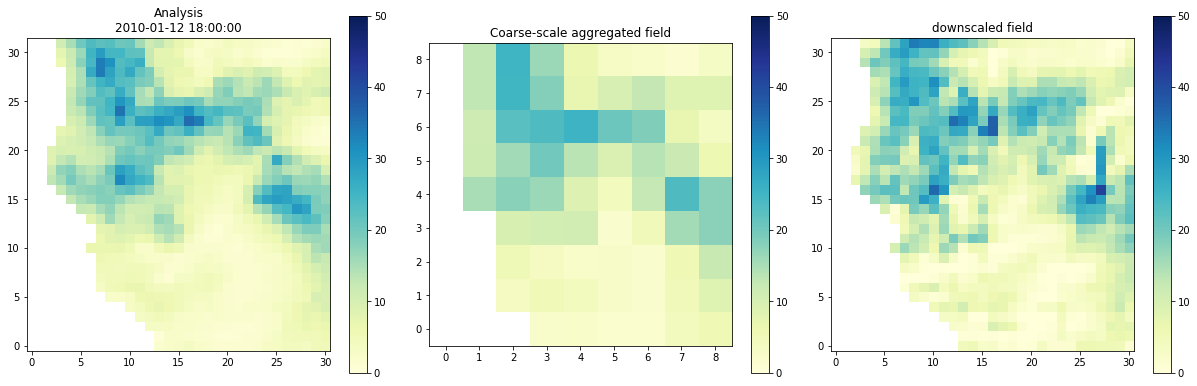

In [390]:
n = 0
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(17,5.4))
ims = ax1.imshow(N_fineFields[n,:,:], origin='lower', cmap='YlGnBu', vmin=0, vmax=50)
cbar = plt.colorbar(ims, ax=ax1)
ax1.set_title('Analysis\n'+str(date_end6h[n]))
ims = ax2.imshow(N_coarseFields[n,:,:], origin='lower', cmap='YlGnBu', vmin=0, vmax=50)
cbar = plt.colorbar(ims, ax=ax2)
ax2.set_title('Coarse-scale aggregated field')
ims = ax3.imshow(N_downFields[n,:,:], origin='lower', cmap='YlGnBu', vmin=0, vmax=50)
cbar = plt.colorbar(ims, ax=ax3)
ax3.set_title('downscaled field')
plt.tight_layout()
plt.show()

Some GSDM variants don't use all the 3 predictors (e.g., E21S20, which uses ADP only). In that case, just provide, for the non-used predictors, arrays with the correct shape but with whatever values, as it is done for E30S20 in the first example.

## 1.3 Use of the orographic enhancement

With the orographic precipitation enhancement activated in the GSDM (character `'o'` at the end of `modelE`), at the end of each Gibbs sampling iteration the precipitation at each fine-scale pixel is increased or decreased, depending on how much wetter or drier than its neighborhood this pixel is, on average. 

This information is contained in an array `relDiff_C_av`, an argument of the function `GSDM_njit` that we have so far ignored. This array gives the relative difference between the climatology at pixel $(i,j)$ and its average over a square window of size `L_oro`. To introduce some uncertainty, we consider that the climatology at pixel $(i,j)$ is not the average of all historical fields we want to compute the climatalogy over, but the average of a random selection of these fields, with `B` the number of fields that are randomly selected (with replacement).

The tunable parameters of this precipitation enhancement method, `L_oro` and `B`,  are defined in a dictionnary `par_Penh`:

In [391]:
par_Penh = dict(L_oro=2, B=100)

With this defined, we can compute `relDiff_C_av` from all the analyses that are in `N_fineFields` (although generally we would use a different period than the one we are gonna downscaled over):

In [392]:
relDiff_C_av = compute_relDiff_C_av(N_fineFields, mask_fine, B=par_Penh['B'], L_oro=par_Penh['L_oro'], seed=seed)

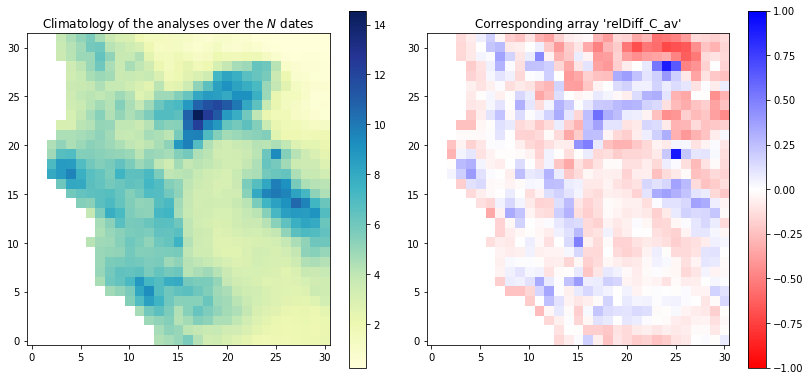

In [393]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11.5,5.4))
ims = ax1.imshow(np.mean(N_fineFields, axis=0), origin='lower', cmap='YlGnBu')
cbar = plt.colorbar(ims, ax=ax1)
ax1.set_title('Climatology of the analyses over the $N$ dates')
ims = ax2.imshow(ma.array(relDiff_C_av, mask=mask_fine), origin='lower', cmap='bwr_r', vmin=-1, vmax=1)
cbar = plt.colorbar(ims, ax=ax2)
ax2.set_title("Corresponding array 'relDiff_C_av'")
plt.tight_layout()
plt.show()

When downscaling, for each $n\in N$ a new `relDiff_C_av` is computed, such that the precipitation enhancement is stochastic rather than deterministic:

(Remark: we compute `relDiff_C_av` from all analysis fields in `N_fineFields`, except the n-th one that correspond to the one being downscaled)


In [394]:
modelE = 'E42o'
modelS = 'S31'
parE = np.array([1.1, 0.02, 0.008, 0.5])
parS = np.array([0.1, 0.00065, 0.04])

N_downFields_without_OroEnh = N_downFields.copy()   # We save them to do a comparison later
N_downFields = ma.array(np.zeros_like(N_fineFields), mask=True)
for n in range(N):

    relDiff_C_av = compute_relDiff_C_av(np.take(N_fineFields, list(range(n))+list(range(n+1,N)), axis=0),
                                        mask_field=mask_fine, B=par_Penh['B'], L_oro=par_Penh['L_oro'], 
                                        seed=seed*n)
    N_downFields[n,:,:] = GSDM_njit(modelE, modelS, parE, parS,
                                    coarse_field=ma.filled(N_coarseFields[n,:,:], fill_value=0.),
                                    closest_cell=closest_cell, 
                                    ASP=ma.filled(windSpeed_700[n,:,:], fill_value=0.),
                                    ADP=ma.filled(windDir_700[n,:,:], fill_value=0.),
                                    SVP=ma.filled(CAPE[n,:,:], fill_value=0.),
                                    relDiff_C_av=relDiff_C_av,
                                    mask_field=mask_fine, 
                                    rs_pred3_spVar=rs_pred3_spVar,
                                    N_iter=par_GSDM['N_iter'], 
                                    seed=seed*n)

N_downFields.mask = mask_fine[None,:,:]

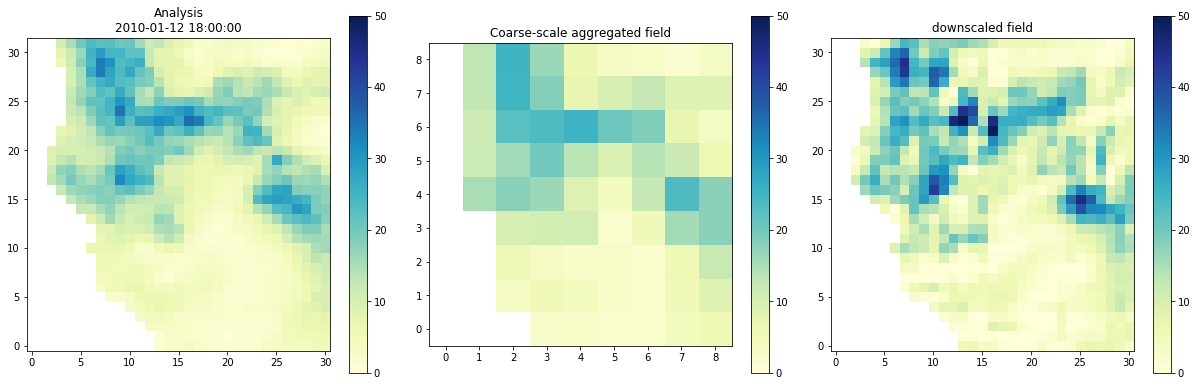

In [395]:
n = 0
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(17,5.4))
ims = ax1.imshow(N_fineFields[n,:,:], origin='lower', cmap='YlGnBu', vmin=0, vmax=50)
cbar = plt.colorbar(ims, ax=ax1)
ax1.set_title('Analysis\n'+str(date_end6h[n]))
ims = ax2.imshow(N_coarseFields[n,:,:], origin='lower', cmap='YlGnBu', vmin=0, vmax=50)
cbar = plt.colorbar(ims, ax=ax2)
ax2.set_title('Coarse-scale aggregated field')
ims = ax3.imshow(N_downFields[n,:,:], origin='lower', cmap='YlGnBu', vmin=0, vmax=50)
cbar = plt.colorbar(ims, ax=ax3)
ax3.set_title('downscaled field')
plt.tight_layout()
plt.show()

Let's finally plot the climatologies of the downscaled fields with and without the precipitation enhamcement activated:

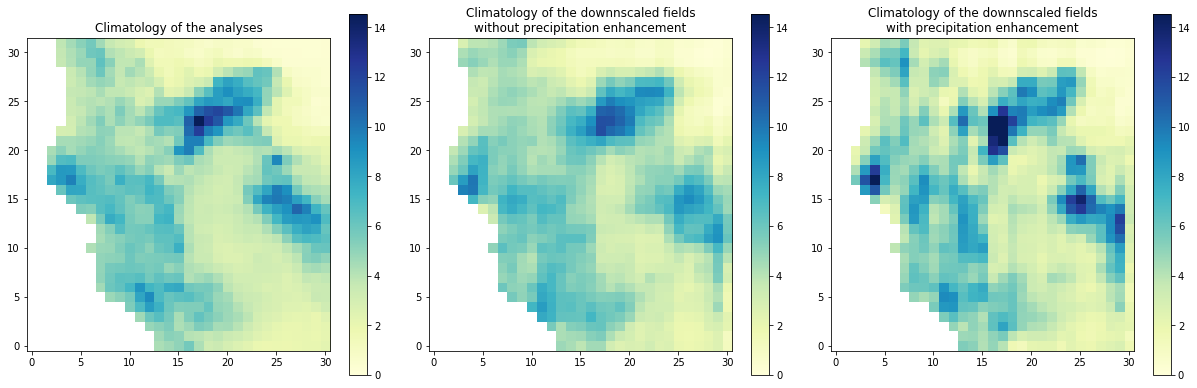

In [396]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(17,5.4))
vmax = np.max(np.mean(N_fineFields, axis=0))
ims = ax1.imshow(np.mean(N_fineFields, axis=0), origin='lower', cmap='YlGnBu', vmin=0, vmax=vmax)
cbar = plt.colorbar(ims, ax=ax1)
ax1.set_title('Climatology of the analyses')
ims = ax2.imshow(np.mean(N_downFields_without_OroEnh, axis=0), origin='lower', cmap='YlGnBu', vmin=0, vmax=vmax)
cbar = plt.colorbar(ims, ax=ax2)
ax2.set_title('Climatology of the downnscaled fields\nwithout precipitation enhancement')
ims = ax3.imshow(np.mean(N_downFields, axis=0), origin='lower', cmap='YlGnBu', vmin=0, vmax=vmax)
cbar = plt.colorbar(ims, ax=ax3)
ax3.set_title('Climatology of the downnscaled fields\nwith precipitation enhancement')
plt.tight_layout()
plt.show()

# 2. Calibrating the GSDM

To find the optimal parameters of the GSDM, we minimize a cost function that quantifies the differences in texture, but also in climatology, between the set of analyses and of downscaled fields. The objective is to have downscaled fields that "look" as similar as possible to the analyses, but also that reproduce, on average, the same orographic patterns as the analyses.

The difference in texture is quantified using the Gridded, Stratified Variogram (GSV). The difference in GSV between the analysis and the downscaled field is evaluated for each $n \in N$, and the average over all $N$ pairs is reported. The difference in climatology, as its name suggests, is the difference between the climatology of the $N$ analyses and that of the $N$ downscaled fields. The cost function will be a weighted function of these two quantities, with weights to be defined by the user.

## 2.1 Evaluating the cost function

Let's start with computing the cost function for a given set of GSDM parameter, using the function `CF_mixTextureClim()`. All of this is included in the calibration function `calib_GSDM_mixTextureClim()` we introduce later, so the user does not have to reproduce this section. However it may help for better understanding the calibration process.

To compute the GSV, we will need to define some GSV parameters: 

In [397]:
par_GSV = dict(grid_size=1, nstrata=3, transform_power=0.5, variogram_power=1)
thresh_wetPix = 0.1

- `grid_size` corresponds to $L$ in Bellier et al. (2020), `nstrata` to $K$, `transform_power` to $\alpha$, while `variogram_power` has been fixed to 1 in the paper.

- `thresh_wetPix` is the minimum percentage of wet pixels in a field for the GSV to be computed, otherwise it is skipped (`thresh_wetPix` will later be defined in the dictionnary `par_optim`):

To make the computation of `CF_mixTextureClim()` faster, we will give as input the $N$ GSV of the analyses, as these do not need to be computed every time (unlike the GSV of the downscaled fields, which change when GSDM parameters change). So let's compute these analysis GSV:

In [398]:
Ngsv_anal = np.zeros((N,par_GSV['nstrata'],2*par_GSV['grid_size']+1,2*par_GSV['grid_size']+1), dtype=np.float64)
for n in range(N):
    if np.sum(N_fineFields[n,:,:] > 0) >= (nya*nxa*thresh_wetPix) and np.sum(N_coarseFields[n,:,:] > 0) >= (nyc*nxc*thresh_wetPix):
        try:
            Ngsv_anal[n,:,:,:] = GSV(ma.filled(N_fineFields[n,:,:], fill_value=999), 
                                     grid_size=par_GSV['grid_size'], 
                                     nstrata=par_GSV['nstrata'], 
                                     transform_power=par_GSV['transform_power'], 
                                     variogram_power=par_GSV['variogram_power'], 
                                     masked_value=999)
        except GSV_stratification_error:
            pass

`GSV_stratification_error` is a custom error that `GSV()` may (rarely) raise when the input field has enough wet pixels but only a few different precipitation values, which causes the stratification, and thus the computation of the GSV, impossible. These occcurences are caught so that the GSV is not computed (the date is discarded, as if there were not enough wet pixels).


Finally, we also need to define some tunable parameters for the cost function:



In [399]:
par_CF = dict(w_txtr_clim=[0.9,0.1], N_draws=1, seed=123)

- `w_txtr_clim` specifies the weights of the texture and climatology components of the cost function. Even if these components are standardized by their "average value", we have found that [0.5, 0.5] still gives quite too much weight on the climatology component, hence we suggest [0.9,0.1]. 
- `N_draws` is the number of times the GSDM is replicated for each date $n\in N$ in the calibration period, with the idea of reducing sampling variability. We have found though that if $N$ is large enough, `N_draws` can reasonnably be set to 1. 
- `seed` is the random seed that must be fixed so that the optimization function can converge to a solution.

Now, we can compute the cost function for a given GSDM variant, set of predictors and parameters:

In [400]:
modelE = 'E32'
modelS = 'S20'
parE = np.array([1.1, 0.02, 0.008])
parS = np.array([0.1, 0.00065])

costFunction = CF_mixTextureClim(np.append(parE, parS), modelE, modelS, 
                                 Ncoarse_fields=N_coarseFields, 
                                 Npred_fields=[windSpeed_700, windDir_700, np.zeros((N,nya,nxa))],
                                 rs_pred3_spVar='positive', 
                                 closest_cell=closest_cell, 
                                 Ngsv_anal=Ngsv_anal, 
                                 Nfine_fields=N_fineFields, 
                                 mask_field=mask_fine, 
                                 par_CF=par_CF, par_GSV=par_GSV, par_GSDM=par_GSDM, par_Penh=par_Penh)
print(costFunction)

0.25011687517411074


## 2.2 Simple optimization

The minimization of the cost function is performed in the function `calib_GSDM_mixTextureClim()`, which implements a constrained Nelder-Mead optimizer. To run it, one must first define some tunable parameters:

In [186]:
par_optim = dict(thresh_wetPix=0.1, nb_fun_eval=50, get_detailedCF=True, verbose=True)

- `thresh_wetPix` has already been described earlier. 

- `nb_fun_eval` is the maximum number of cost function evaluations allowed in the minimization process. We here limit to 25 for this notebook to run fast, but values such as 200 or 500 are normally recommended. Note that termination of the minimization can also be reached by other ways, see the description of the the optimizer `constrNM()`. 

- `get_detailedCF`, if `True`, allows the function to return not only the weighted cost function (start and optimal), but also the "full-texture" (as with `w_txtr_clim=[1.,0.]`) and the "full-climatology" (as with `w_txtr_clim=[0.,1.]`) cost functions (start and optimal).

Let's proceed to the minimization:

In [187]:
modelE = 'E32'
modelS = 'S20'
resultOptim = calib_GSDM_mixTextureClim(modelE, modelS, 
                                        Nfine_fields=N_fineFields, 
                                        Npred_fields=[windSpeed_700, windDir_700, np.zeros((N,nya,nxa))], 
                                        rs_pred3_spVar='positive', 
                                        latLon_analFcst=[lat_fine, lon_fine, lat_coarse, lon_coarse],
                                        Ncoarse_fields=None, 
                                        mask_field=mask_fine, 
                                        par_start=np.append(parE, parS), 
                                        par_optim=par_optim, par_CF=par_CF, par_GSV=par_GSV, par_GSDM=par_GSDM, par_Penh=par_Penh, 
                                        fullNamePred=['windSpeed_700','windDir_700',None],
                                        verbose=True)
par_opt = resultOptim['par_opt']

f_start: 0.25011687517411074
par_start: [1.1e+00 2.0e-02 8.0e-03 1.0e-01 6.5e-04]
After 50 iterations:
  f_opt: 0.1388266837311579
  par_opt: [9.63618089e-01 5.64953450e-02 6.54668410e-04 1.85215629e-01
 1.03124252e-01]


- Note that it possible to  set `par_start=None`, in which case the optimization starts with internally defined parameter values (specific to each model).
- `fullNamePred` is not important at this point, it can be anything (it becomes useful with the step-by-step optimization). 

## 2.3 Step-by-step optimization

For the most sophisticated GSDM variants (e.g., E42oS31), there can be up to 7 free parameters to optimize, and given that Nelder-Mead is a local optimization method, there is a strong risk of ending in a local optimum. To reduce that risk, we propose a sequential, or "step-by-step", calibration procedure that is based on the progressive complexification of the GSDM variant to be calibrated. This is implemented in the function `calib_GSDM_mixTextureClim_stepByStep()`, which calibrates several levels of "parent models", each time starting with the optimial parameters frorm the previous level. The function determines automatically the different levels of parent models, and divides the maximum number of iterations (provided in `par_optim['nb_fun_eval']`) according to the number of new parameters to optimize at each step.

In the example below, the GSDM variant to be calibrated is E32S20 (with predictors windSpeed_700 and windDir_700). The model E32 has E21 and E10 as parent models, while model S20 has S10 as parent. The step-by-step procedure will therefore start calibrating E10S10, then E21S20 using the optimal parameters from E10S10, and finally E32S20 using the optimal partameters from E21S20.

In [184]:
modelE = 'E32'
modelS = 'S20'
resultOptim2 = calib_GSDM_mixTextureClim_stepByStep(modelE, modelS, 
                                                    Nfine_fields=N_fineFields, 
                                                    Npred_fields=[windSpeed_700, windDir_700, np.zeros((N,nya,nxa))], 
                                                    rs_pred3_spVar='positive', 
                                                    latLon_analFcst=[lat_fine, lon_fine, lat_coarse, lon_coarse],
                                                    Ncoarse_fields=None, 
                                                    mask_field=mask_fine, 
                                                    par_start=None, 
                                                    par_optim=par_optim, par_CF=par_CF, par_GSV=par_GSV, par_GSDM=par_GSDM, par_Penh=par_Penh, 
                                                    fullNamePred=['windSpeed_700','windDir_700',None], 
                                                    previous_results_optims=None)    # Will be discussed below
par_opt = resultOptim2[-1]['par_opt']

E10 S10 ['None', 'None', 'None'], 20 iter max
   CF mix: 0.305 -> 0.226
   Txtr: 0.305 -> 0.226
   Clim: 0.17 -> 0.171
   pars: [0.2 0.1] -> [0.33324 0.52254]

E21 S20 ['None', 'windDir_700', 'None'], 20 iter max
   CF mix: 0.226 -> 0.218
   Txtr: 0.226 -> 0.218
   Clim: 0.171 -> 0.171
   pars: [0.33324 0.      0.52254 0.     ] -> [0.12732 0.00001 0.5464  0.01108]

E32 S20 ['windSpeed_700', 'windDir_700', 'None'], 10 iter max
   CF mix: 0.218 -> 0.182
   Txtr: 0.218 -> 0.182
   Clim: 0.171 -> 0.174
   pars: [0.12732 0.00001 0.      0.5464  0.01108] -> [0.12732 0.00001 0.      0.5464  0.05132]



The function `calib_GSDM_mixTextureClim_stepByStep()` also has an argument `previous_results_optims`, which enables to provide a list of previous optimization results from which it will search if the optimization hasn't already been done for a given parent model and predictors.

The argument `fullNamePred` must then be used to make sure that the correct optimization results are drawn from `previous_results_optims`. For that, the naming of the predictors must be consistent from one optimization to the other.

In the example below, we want to optimize the GSDM variant E42oS31, with the same predictors windSpeed_700 and windDir_700 for ASP and ADP, but adding CAPE for SVP. We set `previous_results_optims=[resultOptim2]`, such that the optimization for E10S10 and E21S20, whose results are already contained in `resultOptim2`, don't have to be performed again. Note that `previous_results_optims` must be a list ; in this example we provide only `resultOptim2`, but there can be any number.

In [188]:
modelE = 'E42o'
modelS = 'S31'
resultOptim3 = calib_GSDM_mixTextureClim_stepByStep(modelE, modelS, 
                                                    Nfine_fields=N_fineFields, 
                                                    Npred_fields=[windSpeed_700, windDir_700, CAPE], 
                                                    rs_pred3_spVar='positive', 
                                                    latLon_analFcst=[lat_fine, lon_fine, lat_coarse, lon_coarse],
                                                    Ncoarse_fields=None, 
                                                    mask_field=mask_fine, 
                                                    par_start=None, 
                                                    par_optim=par_optim, par_CF=par_CF, par_GSV=par_GSV, par_GSDM=par_GSDM, par_Penh=par_Penh, 
                                                    fullNamePred=['windSpeed_700','windDir_700','CAPE'], 
                                                    previous_results_optims=[resultOptim2])
par_opt = resultOptim3[-1]['par_opt']

E10 S10 ['None', 'None', 'None'], optimization already done
   CF mix: 0.305 -> 0.226
   Txtr: 0.305 -> 0.226
   Clim: 0.17 -> 0.171
   pars: None -> [0.33324 0.52254]

E21 S20 ['None', 'windDir_700', 'None'], optimization already done
   CF mix: 0.226 -> 0.218
   Txtr: 0.226 -> 0.218
   Clim: 0.171 -> 0.171
   pars: None -> [0.12732 0.00001 0.5464  0.01108]

E32 S31 ['windSpeed_700', 'windDir_700', 'CAPE'], 14 iter max
   CF mix: 0.218 -> 0.182
   Txtr: 0.218 -> 0.182
   Clim: 0.171 -> 0.174
   pars: [0.12732 0.00001 0.      0.5464  0.01108 0.     ] -> [0.12732 0.00001 0.      0.5464  0.05132 0.     ]

E42o S31 ['windSpeed_700', 'windDir_700', 'CAPE'], 7 iter max
   CF mix: 0.135 -> 0.135
   Txtr: 0.14 -> 0.14
   Clim: 0.085 -> 0.086
   pars: [0.12732 0.00001 0.      0.6355  0.5464  0.05132 0.     ] -> [0.12732 0.01445 0.      0.6355  0.5464  0.05132 0.     ]



## 2.4 Step-by-step optimization with multiple candidates of GSDM variants and predictors  <a id=’subsec_calib_multiple_candidates’></a>

In this more sophisticated example, we want to determine, among a list of candidates of GSDM variants and predictors, which combination is the most performant, i.e., that leads to the minimal cost function over the calibration sample.

Let's start by loading all the predictors that are stored in `Data/sample_data.nc`, directly regridding the fields to the fine scale, and giving them a name that will be used later in the optimization:

In [402]:
all_pred = ma.array(np.zeros((7,N,nya,nxa)), mask=True)
nc = Dataset('Data/sample_data.nc')
all_pred[0,:,:,:] = regrid_coarse2fine(nc.variables['windSpeed_600'][:][:,id_lat_coarse,:][:,:,id_lon_coarse].copy(),
                                       [lat_fine, lon_fine, lat_coarse, lon_coarse], mask_coarse)
all_pred[1,:,:,:] = regrid_coarse2fine(nc.variables['windSpeed_700'][:][:,id_lat_coarse,:][:,:,id_lon_coarse].copy(),
                                       [lat_fine, lon_fine, lat_coarse, lon_coarse], mask_coarse)
all_pred[2,:,:,:] = regrid_coarse2fine(nc.variables['windDir_600'][:][:,id_lat_coarse,:][:,:,id_lon_coarse].copy(), 
                                       [lat_fine, lon_fine, lat_coarse, lon_coarse], mask_coarse)
all_pred[3,:,:,:] = regrid_coarse2fine(nc.variables['windDir_700'][:][:,id_lat_coarse,:][:,:,id_lon_coarse].copy(), 
                                       [lat_fine, lon_fine, lat_coarse, lon_coarse], mask_coarse)
all_pred[4,:,:,:] = regrid_coarse2fine(nc.variables['WindShearSpeed_sfc_700'][:][:,id_lat_coarse,:][:,:,id_lon_coarse].copy(), 
                                       [lat_fine, lon_fine, lat_coarse, lon_coarse], mask_coarse)
all_pred[5,:,:,:] = regrid_coarse2fine(nc.variables['CAPE'][:][:,id_lat_coarse,:][:,:,id_lon_coarse].copy(), 
                                       [lat_fine, lon_fine, lat_coarse, lon_coarse], mask_coarse)
all_pred[6,:,:,:] = regrid_coarse2fine(nc.variables['LI'][:][:,id_lat_coarse,:][:,:,id_lon_coarse].copy(), 
                                       [lat_fine, lon_fine, lat_coarse, lon_coarse], mask_coarse)
name_all_pred = np.array(['windSpeed_600','windSpeed_700','windDir_600','windDir_700','WindShearSpeed_sfc_700','CAPE','LI'])
nc.close()

From these available predictors, let's stedicfy which ones will be considered as candidate, and for which type of predictor: ASP, ADP or SVP. For ASP and ADP, the candidates are generally wind speed and wind direction, respectively, at given pressure levels, and we decide here that the same level must be considered for the two (e.g., we don't test windSpeed_600 simultaneously with windDir_700)

In [403]:
candid_ASP_ADP = [['windSpeed_600','windDir_600'],['windSpeed_700','windDir_700']]
candid_SVP = ['windSpeed_700','WindShearSpeed_sfc_700','CAPE']
candid_SVP_rs_pred3_spVar = ['negative','negative','positive']

There are therefore 2 candidates for ASP and ADP, and 3 candidates for SVP.

We also specify which GSDM variants will be considered as candidates. We do so by specifying the candidates for modelE and modelS separately, with all combinations being tested. 

In [404]:
candid_modelE = ['E40o','E42o']
candid_modelS = ['S20','S31']    

Let's now determine what are all the possible combinations of modelE, modelS, and predictors:

In [410]:
C_modelE = []
C_modelS = []
C_namePred = []
C_rs_pred3_spVar = []

## Loop over the different GSDM variant to try:
for me in range(len(candid_modelE)):
    for ms in range(len(candid_modelS)):
        modelE = candid_modelE[me]
        modelS = candid_modelS[ms]
        
        ## Loop over the different predictor to try (depending if modelE and/or modelS use predictors):
        if int(modelE[2]) > 0:
            for p1_2 in range(len(candid_ASP_ADP)):
                name_ASP, name_ADP = candid_ASP_ADP[p1_2]
                                            
                if int(modelS[2]) > 0:
                    for p3 in range(len(candid_SVP)):
                        name_SVP, rs_pred3_spVar = candid_SVP[p3], candid_SVP_rs_pred3_spVar[p3]
                        
                        C_modelE.append(modelE)
                        C_modelS.append(modelS)
                        C_namePred.append([name_ASP, name_ADP, name_SVP])
                        C_rs_pred3_spVar.append(rs_pred3_spVar)

                else:
                    name_SVP, rs_pred3_spVar = None, 'no_pred3'
                    
                    C_modelE.append(modelE)
                    C_modelS.append(modelS)
                    C_namePred.append([name_ASP, name_ADP, name_SVP])
                    C_rs_pred3_spVar.append(rs_pred3_spVar)

        else:
            name_ASP, name_ADP = None, None
            
            if int(modelS[2]) > 0:
                for p3 in range(len(candid_SVP)):
                    name_SVP, rs_pred3_spVar = candid_SVP[p3], candid_SVP_rs_pred3_spVar[p3]

                    C_modelE.append(modelE)
                    C_modelS.append(modelS)
                    C_namePred.append([name_ASP, name_ADP, name_SVP])
                    C_rs_pred3_spVar.append(rs_pred3_spVar)
                    
            else:
                name_SVP, rs_pred3_spVar = None, 'no_pred3'
                    
                C_modelE.append(modelE)
                C_modelS.append(modelS)
                C_namePred.append([name_ASP, name_ADP, name_SVP])
                C_rs_pred3_spVar.append(rs_pred3_spVar)

C = len(C_modelE)


print('List of the C='+str(C)+' possible combinations (#, model and predictors used)')
for c in range(C):
    print('c='+str(c)+': '+C_modelE[c]+C_modelS[c]+'  '+str(C_namePred[c]))

List of the C=12 possible combinations (#, model and predictors used)
c=0: E40oS20  [None, None, None]
c=1: E40oS31  [None, None, 'windSpeed_700']
c=2: E40oS31  [None, None, 'WindShearSpeed_sfc_700']
c=3: E40oS31  [None, None, 'CAPE']
c=4: E42oS20  ['windSpeed_600', 'windDir_600', None]
c=5: E42oS20  ['windSpeed_700', 'windDir_700', None]
c=6: E42oS31  ['windSpeed_600', 'windDir_600', 'windSpeed_700']
c=7: E42oS31  ['windSpeed_600', 'windDir_600', 'WindShearSpeed_sfc_700']
c=8: E42oS31  ['windSpeed_600', 'windDir_600', 'CAPE']
c=9: E42oS31  ['windSpeed_700', 'windDir_700', 'windSpeed_700']
c=10: E42oS31  ['windSpeed_700', 'windDir_700', 'WindShearSpeed_sfc_700']
c=11: E42oS31  ['windSpeed_700', 'windDir_700', 'CAPE']


We then perform the calibration for all these combinations. But after the calibration for a combination is finished, we append its `resultOptim` to `C_resultOptim`, which we provide as input for the calibration of the next combination. This greatly reduces the computationnal time of the process, as otherwise the same optimizations would be done several times.

In [195]:
C_resultOptim = []
C_fopt = np.zeros(C)
for c in range(C):
    modelE = C_modelE[c]
    modelS = C_modelS[c]
    namePred = C_namePred[c]
    rs_pred3_spVar = C_rs_pred3_spVar[c]

    print('Combination '+str(c+1)+'/'+str(C)+': '+modelE+'-'+modelS+', '+str(namePred))
    print('------------------------------------------------------------------------------')
            
    ## We select the correct predictors for this combination
    ASP = all_pred[np.where(name_all_pred==namePred[0])[0][0],:,:,:] if namePred[0] is not None else np.zeros((N,nya,nxa))
    ADP = all_pred[np.where(name_all_pred==namePred[1])[0][0],:,:,:] if namePred[1] is not None else np.zeros((N,nya,nxa))
    SVP = all_pred[np.where(name_all_pred==namePred[2])[0][0],:,:,:] if namePred[2] is not None else np.zeros((N,nya,nxa))        
        
    resultOptim = calib_GSDM_mixTextureClim_stepByStep(modelE, modelS, 
                                                       Nfine_fields=N_fineFields, 
                                                       Npred_fields=[ASP, ADP, SVP], 
                                                       rs_pred3_spVar=rs_pred3_spVar, 
                                                       latLon_analFcst=[lat_fine, lon_fine, lat_coarse, lon_coarse],
                                                       Ncoarse_fields=None, 
                                                       mask_field=mask_fine, 
                                                       par_start=None, 
                                                       par_optim=par_optim, par_CF=par_CF, par_GSV=par_GSV, par_GSDM=par_GSDM, par_Penh=par_Penh, 
                                                       fullNamePred=namePred, 
                                                       previous_results_optims=C_resultOptim)
    C_resultOptim.append(resultOptim)
    C_fopt[c] = resultOptim[-1]['f_opt']

Combination 1/12: E40o-S20, [None, None, None]
------------------------------------------------------------------------------
E10 S10 ['None', 'None', 'None'], 17 iter max
   CF mix: 0.305 -> 0.226
   Txtr: 0.305 -> 0.226
   Clim: 0.17 -> 0.171
   pars: [0.2 0.1] -> [0.33324 0.52254]

E30 S20 ['None', 'None', 'None'], 25 iter max
   CF mix: 0.226 -> 0.211
   Txtr: 0.226 -> 0.211
   Clim: 0.171 -> 0.195
   pars: [0.33324 0.      0.      0.52254 0.     ] -> [ 0.12718  0.32837 -0.16233  0.44438  0.00175]

E40o S20 ['None', 'None', 'None'], 8 iter max
   CF mix: 0.169 -> 0.151
   Txtr: 0.172 -> 0.158
   Clim: 0.146 -> 0.082
   pars: [ 0.12718  0.32837 -0.16233  0.45053  0.44438  0.00175] -> [ 0.16213  0.00369 -0.06101  0.58541  0.63726  0.00667]

Combination 2/12: E40o-S31, [None, None, 'windSpeed_700']
------------------------------------------------------------------------------
E10 S10 ['None', 'None', 'None'], optimization already done
   CF mix: 0.305 -> 0.226
   Txtr: 0.305 -> 0.226


We can plot the optimimal cost function (stored in `C_fopt`) for all the combinations:

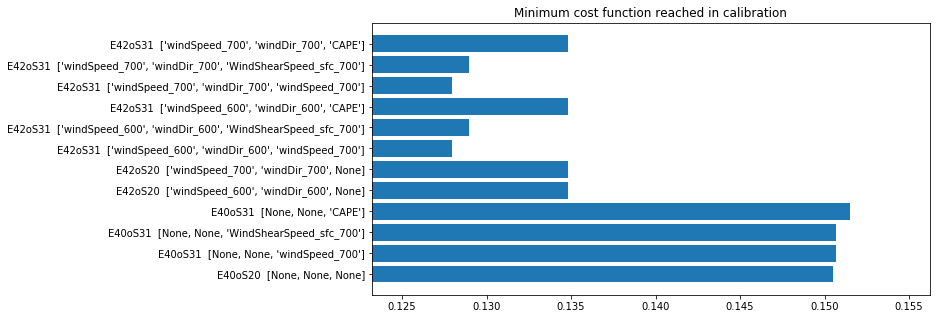

In [198]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.barh(range(C), C_fopt)
plt.yticks(range(C), [C_modelE[c]+C_modelS[c]+'  '+str(C_namePred[c]) for c in range(C)])
plt.xlim([min(C_fopt)-0.2*(max(C_fopt)-min(C_fopt)), max(C_fopt)+0.2*(max(C_fopt)-min(C_fopt))])
plt.title('Minimum cost function reached in calibration')
plt.show()

And select the most performant one:

In [199]:
c_opt = np.argmin(C_fopt)
modelE_opt = C_modelE[c_opt]
modelS_opt = C_modelS[c_opt]
par_opt = C_resultOptim[c_opt][-1]['par_opt']
parE_opt = par_opt[:int(modelE_opt[1])]       # Separate 'parE_opt' and 'parS_opt' from 'par_opt':
parS_opt = par_opt[-int(modelS_opt[1]):]      # 

## We select the correct predictors for this combination
ASP_opt = all_pred[np.where(name_all_pred==C_namePred[c_opt][0])[0][0],:,:,:] if C_namePred[c_opt][0] is not None else np.zeros((N,nya,nxa))
ADP_opt = all_pred[np.where(name_all_pred==C_namePred[c_opt][1])[0][0],:,:,:] if C_namePred[c_opt][1] is not None else np.zeros((N,nya,nxa))
SVP_opt = all_pred[np.where(name_all_pred==C_namePred[c_opt][2])[0][0],:,:,:] if C_namePred[c_opt][2] is not None else np.zeros((N,nya,nxa))        
rs_pred3_spVar_opt = C_rs_pred3_spVar[c_opt]

Let's now perform the downscaling of the $N$ coarse-scale fields, with the optimal downscaling configuration (i.e., GSDM variant, set of predictors, parameters):

In [200]:
N_downFields = ma.array(np.zeros_like(N_fineFields), mask=True)
for n in range(N):
    
    ## We need  to compute relDiff_C_av only if modelE_opt has the orographic component activated:
    if modelE_opt[-1] == 'o':
        relDiff_C_av = compute_relDiff_C_av(np.take(N_fineFields, list(range(n))+list(range(n+1,N)), axis=0),
                                            mask_field=mask_fine, B=par_Penh['B'], L_oro=par_Penh['L_oro'], 
                                            seed=seed*n)
    else:
        relDiff_C_av = np.zeros((nya,nxa))
        
    N_downFields[n,:,:] = GSDM_njit(modelE_opt, modelS_opt, parE_opt, parS_opt,
                                    coarse_field=ma.filled(N_coarseFields[n,:,:], fill_value=0.),
                                    closest_cell=closest_cell, 
                                    ASP=ma.filled(ASP_opt[n,:,:], fill_value=0.),
                                    ADP=ma.filled(ADP_opt[n,:,:], fill_value=0.),
                                    SVP=ma.filled(SVP_opt[n,:,:], fill_value=0.),
                                    relDiff_C_av=relDiff_C_av,
                                    mask_field=mask_fine, 
                                    rs_pred3_spVar=rs_pred3_spVar_opt,
                                    N_iter=par_GSDM['N_iter'], 
                                    seed=seed*n)

N_downFields.mask = mask_fine[None,:,:]

Downscaled field for the first date:

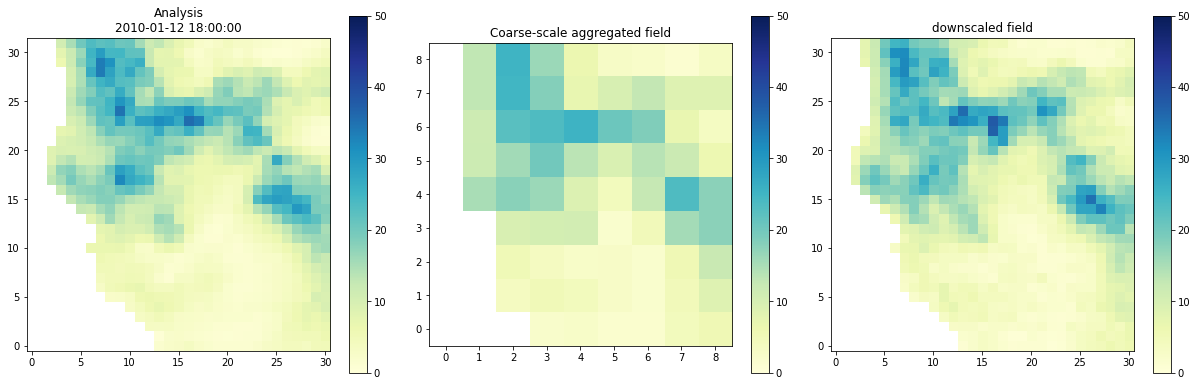

In [202]:
n = 0
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(17,5.4))
ims = ax1.imshow(N_fineFields[n,:,:], origin='lower', cmap='YlGnBu', vmin=0, vmax=50)
cbar = plt.colorbar(ims, ax=ax1)
ax1.set_title('Analysis\n'+str(date_end6h[n]))
ims = ax2.imshow(N_coarseFields[n,:,:], origin='lower', cmap='YlGnBu', vmin=0, vmax=50)
cbar = plt.colorbar(ims, ax=ax2)
ax2.set_title('Coarse-scale aggregated field')
ims = ax3.imshow(N_downFields[n,:,:], origin='lower', cmap='YlGnBu', vmin=0, vmax=50)
cbar = plt.colorbar(ims, ax=ax3)
ax3.set_title('downscaled field')
plt.tight_layout()
plt.show()

And the climatologies:

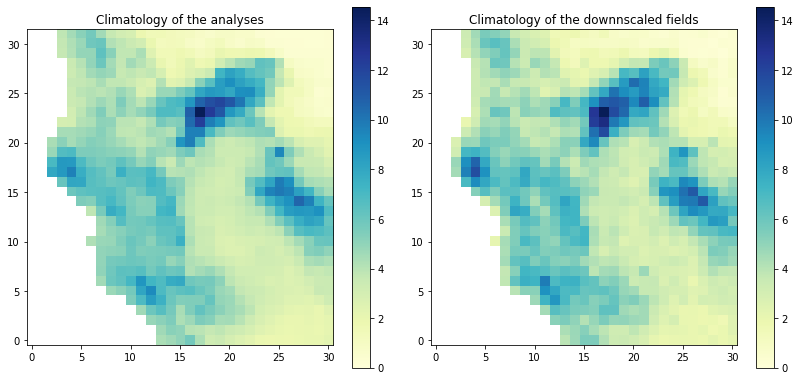

In [204]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11.5,5.4))
vmax = np.max(np.mean(N_fineFields, axis=0))
ims = ax1.imshow(np.mean(N_fineFields, axis=0), origin='lower', cmap='YlGnBu', vmin=0, vmax=vmax)
cbar = plt.colorbar(ims, ax=ax1)
ax1.set_title('Climatology of the analyses')
ims = ax2.imshow(np.mean(N_downFields, axis=0), origin='lower', cmap='YlGnBu', vmin=0, vmax=vmax)
cbar = plt.colorbar(ims, ax=ax2)
ax2.set_title('Climatology of the downnscaled fields')
plt.tight_layout()
plt.show()

# 3. Use of the GSDM over a large domain

The GSDM assumes some form of stationnarity of the precipitation process over the downscaling domain. However, this assumption certainly does not hold for large domains. 

For users who want to downscale precipitation fields over large domains, we propose a procedure that consists in calibrating the GSDM over subdomains independantly, and then applying the GSDM over the large domain, but with an adapted version that allows to pick different parameters for each subdomain. 

For this example let's load the analyses over the entire domain:

In [228]:
nc = Dataset('Data/sample_data.nc')
lat_fine_lgD = nc.variables['lat_fine'][:]
lon_fine_lgD = nc.variables['lon_fine'][:]
N_fineFields_lgD = nc.variables['fine_fields'][:]
mask_fine_lgD = N_fineFields_lgD[0,:,:].mask
yyyymmddhh_end6h = nc.variables['yyyymmddhh_end6h'][:]
date_end6h = yyyymmddhh_to_date(yyyymmddhh_end6h)
nc.close()

N, nyad, nxad = N_fineFields_lgD.shape

In [229]:
nc = Dataset('Data/sample_data.nc')
lat_coarse_lgD = nc.variables['lat_coarse'][:]
lon_coarse_lgD = nc.variables['lon_coarse'][:]
nc.close()

N_coarseFields_lgD = aggregate_fine2coarse(Nfine_fields=N_fineFields_lgD, 
                                       latLon_analFcst=[lat_fine_lgD, lon_fine_lgD, lat_coarse_lgD, lon_coarse_lgD],
                                       mask_field=mask_fine_lgD)
N, nycd, nxcd = N_coarseFields_lgD.shape
mask_coarse_lgD = N_coarseFields_lgD[0,:,:].mask

In [23]:
closest_cell_lgD = get_closest_cell_mat(lon_coarse_lgD, lat_coarse_lgD, lon_fine_lgD, lat_fine_lgD)

We then divide this large domain into `D` subdomains, using boxes of approximately ~4x4 degrees. Here, this is done manually, given the particular shape of the large domain (large areas at the boundary of the domain are over sea, or masked).

In [312]:
D_boundsArea = [[41.7, 45.5, -124.7, -120.],
                [41.7, 45.5, -120., -115.5],
                [37.9, 41.7, -124.7, -121.2],
                [37.9, 41.7, -121.2, -117.8],
                [37.9, 41.7, -117.8, -114.3],
                [34.1, 37.9, -123., -117.8],
                [34.1, 37.9, -117.8, -113.3],
                [30.8, 34.1, -120.9, -113.3]]
D = len(D_boundsArea)

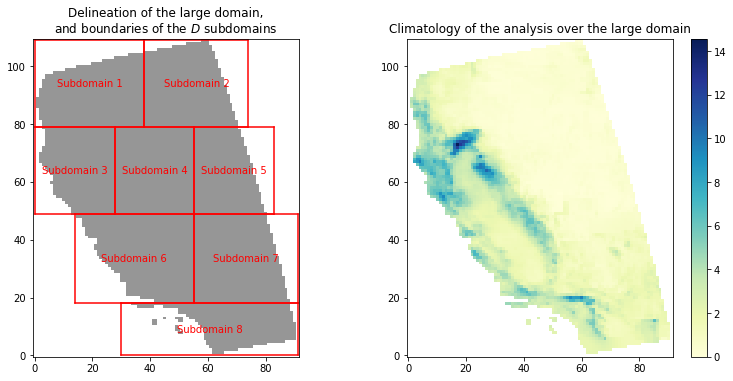

In [313]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11,5.4))
vmax = np.max(np.mean(N_fineFields_lgD, axis=0))
ims = ax1.imshow(mask_fine_lgD, origin='lower', cmap='Greys_r', vmin=-1)
ax1.set_title('Delineation of the large domain,\nand boundaries of the $D$ subdomains')
for d in range(D):
    lb_lat, ub_lat, lb_lon, ub_lon = D_boundsArea[d]
    lb_j = np.argmin(np.abs(lat_fine_lgD-lb_lat))
    ub_j = np.argmin(np.abs(lat_fine_lgD-ub_lat))
    lb_i = np.argmin(np.abs(lon_fine_lgD-lb_lon))
    ub_i = np.argmin(np.abs(lon_fine_lgD-ub_lon))
    ax1.plot([lb_i,lb_i],[lb_j,ub_j], color='red')
    ax1.plot([ub_i,ub_i],[lb_j,ub_j], color='red')
    ax1.plot([lb_i,ub_i],[lb_j,lb_j], color='red')
    ax1.plot([lb_i,ub_i],[ub_j,ub_j], color='red')
    ax1.text(lb_i+(ub_i-lb_i)/2,lb_j+(ub_j-lb_j)/2,'Subdomain '+str(d+1), color='red', ha='center', va='center')
    
ims = ax2.imshow(np.mean(N_fineFields_lgD, axis=0), origin='lower', cmap='YlGnBu', vmin=0, vmax=vmax)
cbar = plt.colorbar(ims, ax=ax2)
ax2.set_title('Climatology of the analysis over the large domain')

plt.tight_layout()
plt.show()

## 3.1 Calibration over the individual subdomains

In the previous section, we have performed the optimization of the GSDM for multiple combinations of GSDM variants and predictors, with the idea of keeping the best one. We can implement the same procedure here, but for each subdomain individually.

In order to make this example faster to run, though, we will limit here to a only 2 combinations of GSDM variant and predictor (one can easily add more combinations to test, if desired):

In [426]:
## We here manually fill the list of combinations:
C = 2
C_modelE = ['E42o','E42o']
C_modelS = ['S31','S31']
C_namePred = [['windSpeed_700', 'windDir_700', 'windSpeed_700'],['windSpeed_600', 'windDir_600', 'WindShearSpeed_sfc_700']]
C_rs_pred3_spVar = ['negative','negative']

Let's recall the dictionnaries of tunable parameters we will need:

In [40]:
par_optim = dict(thresh_wetPix=0.1, nb_fun_eval=50, get_detailedCF=False, verbose=True)
par_CF = dict(w_txtr_clim=[0.9,0.1], N_draws=1, seed=123)
par_GSV = dict(grid_size=1, nstrata=3, transform_power=0.5, variogram_power=1)
par_GSDM = dict(N_iter=10)

The calibration procedure loops over each subdomain, loads the necessary data for that subdomain, and then loops over the combinations as in the previous example with a single domain:

In [41]:
## Loop over the subdomains:
DC_resultOptim = []
DC_fopt = np.zeros((D,C))
for d in range(D):
    lb_lat, ub_lat, lb_lon, ub_lon = D_boundsArea[d]
    
    ## Load the analyses for that subdomain:
    nc = Dataset('Data/sample_data.nc')
    id_lat_fine = np.logical_and(nc.variables['lat_fine'][:] >= lb_lat, nc.variables['lat_fine'][:] <= ub_lat)
    id_lon_fine = np.logical_and(nc.variables['lon_fine'][:] >= lb_lon, nc.variables['lon_fine'][:] <= ub_lon)
    lat_fine = nc.variables['lat_fine'][:][id_lat_fine]
    lon_fine = nc.variables['lon_fine'][:][id_lon_fine]
    N_fineFields = nc.variables['fine_fields'][:][:,id_lat_fine,:][:,:,id_lon_fine].copy()
    mask_fine = N_fineFields[0,:,:].mask
    yyyymmddhh_end6h = nc.variables['yyyymmddhh_end6h'][:]
    date_end6h = yyyymmddhh_to_date(yyyymmddhh_end6h)
    nc.close()
    N, nya, nxa = N_fineFields.shape
    
    ## Aggregate them to the coarse scale:
    nc = Dataset('Data/sample_data.nc')
    id_lat_coarse = np.logical_and(nc.variables['lat_coarse'][:] >= lb_lat, nc.variables['lat_coarse'][:] <= ub_lat)
    id_lon_coarse = np.logical_and(nc.variables['lon_coarse'][:] >= lb_lon, nc.variables['lon_coarse'][:] <= ub_lon)
    lat_coarse = nc.variables['lat_coarse'][:][id_lat_coarse]
    lon_coarse = nc.variables['lon_coarse'][:][id_lon_coarse]
    nc.close()
    N_coarseFields = aggregate_fine2coarse(Nfine_fields=N_fineFields, 
                                           latLon_analFcst=[lat_fine, lon_fine, lat_coarse, lon_coarse],
                                           mask_field=mask_fine)
    N, nyc, nxc = N_coarseFields.shape
    mask_coarse = N_coarseFields[0,:,:].mask
    
    ## Compute the array 'closest_cell' for that subdomain:
    closest_cell = get_closest_cell_mat(lon_coarse, lat_coarse, lon_fine, lat_fine)
    
    ## Load the predictors for that subdomain:
    ##    (remark: we here load all the predictors, although it is not necessary here):
    all_pred = ma.array(np.zeros((7,N,nya,nxa)), mask=True)
    nc = Dataset('Data/sample_data.nc')
    all_pred[0,:,:,:] = regrid_coarse2fine(nc.variables['windSpeed_600'][:][:,id_lat_coarse,:][:,:,id_lon_coarse].copy(), 
                                           [lat_fine, lon_fine, lat_coarse, lon_coarse], mask_coarse)
    all_pred[1,:,:,:] = regrid_coarse2fine(nc.variables['windSpeed_700'][:][:,id_lat_coarse,:][:,:,id_lon_coarse].copy(), 
                                           [lat_fine, lon_fine, lat_coarse, lon_coarse], mask_coarse)
    all_pred[2,:,:,:] = regrid_coarse2fine(nc.variables['windDir_600'][:][:,id_lat_coarse,:][:,:,id_lon_coarse].copy(), 
                                           [lat_fine, lon_fine, lat_coarse, lon_coarse], mask_coarse)
    all_pred[3,:,:,:] = regrid_coarse2fine(nc.variables['windDir_700'][:][:,id_lat_coarse,:][:,:,id_lon_coarse].copy(), 
                                           [lat_fine, lon_fine, lat_coarse, lon_coarse], mask_coarse)
    all_pred[4,:,:,:] = regrid_coarse2fine(nc.variables['WindShearSpeed_sfc_700'][:][:,id_lat_coarse,:][:,:,id_lon_coarse].copy(), 
                                           [lat_fine, lon_fine, lat_coarse, lon_coarse], mask_coarse)
    all_pred[5,:,:,:] = regrid_coarse2fine(nc.variables['CAPE'][:][:,id_lat_coarse,:][:,:,id_lon_coarse].copy(), 
                                           [lat_fine, lon_fine, lat_coarse, lon_coarse], mask_coarse)
    all_pred[6,:,:,:] = regrid_coarse2fine(nc.variables['LI'][:][:,id_lat_coarse,:][:,:,id_lon_coarse].copy(), 
                                           [lat_fine, lon_fine, lat_coarse, lon_coarse], mask_coarse)
    name_all_pred = np.array(['windSpeed_600','windSpeed_700','windDir_600','windDir_700','WindShearSpeed_sfc_700','CAPE','LI'])
    nc.close()
    
        
    ## Loop over the combinations:
    C_resultOptim = []
    for c in range(C):
        modelE = C_modelE[c]
        modelS = C_modelS[c]
        namePred = C_namePred[c]
        rs_pred3_spVar = C_rs_pred3_spVar[c]

        print('Domain '+str(d+1)+'/'+str(D)+'; Combination '+str(c+1)+'/'+str(C)+': '+modelE+'-'+modelS+', '+str(namePred))
        print('------------------------------------------------------------------------------')

        ## We select the correct predictors for this combination
        ASP = all_pred[np.where(name_all_pred==namePred[0])[0][0],:,:,:] if namePred[0] is not None else np.zeros((N,nya,nxa))
        ADP = all_pred[np.where(name_all_pred==namePred[1])[0][0],:,:,:] if namePred[1] is not None else np.zeros((N,nya,nxa))
        SVP = all_pred[np.where(name_all_pred==namePred[2])[0][0],:,:,:] if namePred[2] is not None else np.zeros((N,nya,nxa))        

        ## Optimization:
        resultOptim = calib_GSDM_mixTextureClim_stepByStep(modelE, modelS, 
                                                           Nfine_fields=N_fineFields, 
                                                           Npred_fields=[ASP, ADP, SVP], 
                                                           rs_pred3_spVar=rs_pred3_spVar, 
                                                           latLon_analFcst=[lat_fine, lon_fine, lat_coarse, lon_coarse],
                                                           Ncoarse_fields=None, 
                                                           mask_field=mask_fine, 
                                                           par_start=None, 
                                                           par_optim=par_optim, par_CF=par_CF, par_GSV=par_GSV, par_GSDM=par_GSDM, par_Penh=par_Penh, 
                                                           fullNamePred=namePred, 
                                                           previous_results_optims=C_resultOptim)
        C_resultOptim.append(resultOptim)
        DC_fopt[d,c] = resultOptim[-1]['f_opt']

    DC_resultOptim.append(C_resultOptim)

Domain 1/8; Combination 1/2: E42o-S31, ['windSpeed_700', 'windDir_700', 'windSpeed_700']
------------------------------------------------------------------------------
E10 S10 ['None', 'None', 'None'], 14 iter max
   CF mix: 0.37 -> 0.308
   pars: [0.2 0.1] -> [0.26328 0.23593]

E21 S20 ['None', 'windDir_700', 'None'], 14 iter max
   CF mix: 0.308 -> 0.307
   pars: [0.26328 0.      0.23593 0.     ] -> [0.41612 0.      0.23593 0.     ]

E32 S31 ['windSpeed_700', 'windDir_700', 'windSpeed_700'], 14 iter max
   CF mix: 0.307 -> 0.307
   pars: [0.41612 0.      0.      0.23593 0.      0.     ] -> [0.41612 0.      0.      0.23593 0.00154 0.     ]

E42o S31 ['windSpeed_700', 'windDir_700', 'windSpeed_700'], 7 iter max
   CF mix: 0.272 -> 0.263
   pars: [0.41612 0.      0.      0.6416  0.23593 0.00154 0.     ] -> [0.41612 0.      0.      0.6416  0.23593 0.00154 0.00308]

Domain 1/8; Combination 2/2: E42o-S31, ['windSpeed_600', 'windDir_600', 'WindShearSpeed_sfc_700']
--------------------------

All the optimization results are now stored into the list `DC_resultOptim`. To access, say, the optimal parameters of subdomain `d=4` and combination `c=1`:

In [51]:
d, c = 4, 1
print(DC_resultOptim[d][c][-1]['par_opt'])

[0.02083345 0.00128791 0.         0.68165263 0.74014158 0.02398587
 0.00308267]


- Remark: `DC_resultOptim[d][c]` contains the optimization results for all levels of parent models (because the step-by-step calibration is used), so `[-1]` is necessary if we want to access the last step, which corresponds to the GSDM variant we want to calibrate.

## 3.2 Generation of the downscaled fields

The idea of downscaling over a large domain is not to generate individual downscaled fields over each subdomain and then patch them together, because this would lead to strong visual discontinuities, but rather to apply the GSDM over the entire domain in single, seamless simulation. To do so, we use a new function `GSDM_lgD_njit()`, which is slightly different than the function `GSDM_njit()` in that it allows to use different downscaling configurations (i.e., GSDM variant, set of predictors, parameters) for different areas of the domain.

The first step is to determine, from the optimization results stored in `DC_resultOptim`, what is the optimal downscaling configuration for each subdomain:

In [138]:
D_modelE_opt = []
D_modelS_opt = []
D_namePred_opt = []
D_rs_pred3_spVar_opt = []
for d in range(D):
    c_opt = np.argmin(DC_fopt[d,:])
    D_modelE_opt.append(C_modelE[c_opt])
    D_modelS_opt.append(C_modelS[c_opt])
    D_rs_pred3_spVar_opt.append(C_rs_pred3_spVar[c_opt])
    D_namePred_opt.append(C_namePred[c_opt])
D_modelE_opt = np.array(D_modelE_opt)
D_modelS_opt = np.array(D_modelS_opt)
D_rs_pred3_spVar_opt = np.array(D_rs_pred3_spVar_opt)

## We also put the optimal parameters (for each domain) into 'D_parE_opt' and 'D_parS_opt'
D_parE_opt = np.zeros((D,4))     # 4 = max number of parameters for any modelE
D_parS_opt = np.zeros((D,3))     # 3 = max number of parameters for any modelS
for d in range(D):
    c_opt = np.argmin(DC_fopt[d,:])
    par_opt = DC_resultOptim[d][c_opt][-1]['par_opt']
    D_parE_opt[d,:int(D_modelE_opt[d][1])] = par_opt[:int(D_modelE_opt[d][1])]
    D_parS_opt[d,:int(D_modelS_opt[d][1])] = par_opt[-int(D_modelS_opt[d][1]):]

The next step is to construct an array called `field_parDomain` that will give for each coarse-scale pixel the index of the calibration domain to use the optimal downscaling configuration from.

The simplest way to create this array is to use the boundaries of the subdomains: a coarse-scale pixel $(x,y)$ "belongs" to the subdomain $d$ if its center is within the boundaries of the subdomain. Note that the $D$ subdomains may not cover the large domain entirely, so we perform basic interpolation to make sure that every pixel $(x,y)$ belongs to one subdomain. 

In [343]:
field_parDomain = np.zeros((nycd,nxcd), dtype=np.int32)
for y in range(nycd):
    for x in range(nxcd):
        try:
            field_parDomain[y,x] = np.where([(lat_coarse_lgD[y] >= D_boundsArea[dom][0] and
                                              lat_coarse_lgD[y] <= D_boundsArea[dom][1] and
                                              lon_coarse_lgD[x] >= D_boundsArea[dom][2] and 
                                              lon_coarse_lgD[x] <= D_boundsArea[dom][3]) for dom in range(D)])[0][0]
        except IndexError:   # we do an interpolation
            field_parDomain[y,x] = np.argmin([np.sqrt( (lon_coarse_lgD[x] - (D_boundsArea[dom][2] + (D_boundsArea[dom][3] - D_boundsArea[dom][2])/2))**2 
                                                      + (lat_coarse_lgD[y] - (D_boundsArea[dom][0] + (D_boundsArea[dom][1] - D_boundsArea[dom][0])/2))**2 ) for dom in range(D)])

Plots:

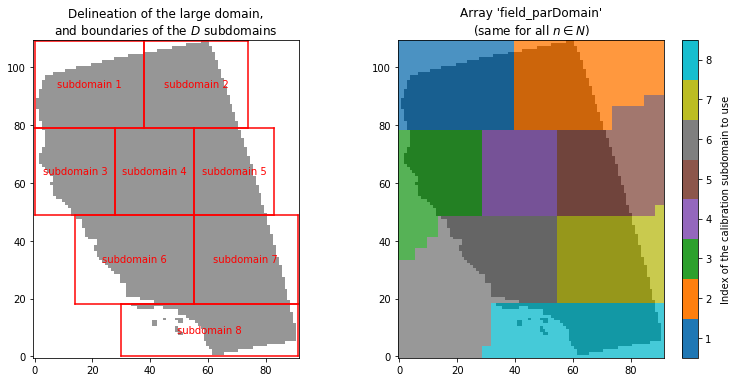

In [344]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11,5.4))
ims = ax1.imshow(mask_fine_lgD, origin='lower', cmap='Greys_r', vmin=-1)
ax1.set_title('Delineation of the large domain,\nand boundaries of the $D$ subdomains')
for d in range(D):
    lb_lat, ub_lat, lb_lon, ub_lon = D_boundsArea[d]
    lb_j = np.argmin(np.abs(lat_fine_lgD-lb_lat))
    ub_j = np.argmin(np.abs(lat_fine_lgD-ub_lat))
    lb_i = np.argmin(np.abs(lon_fine_lgD-lb_lon))
    ub_i = np.argmin(np.abs(lon_fine_lgD-ub_lon))
    ax1.plot([lb_i,lb_i],[lb_j,ub_j], color='red')
    ax1.plot([ub_i,ub_i],[lb_j,ub_j], color='red')
    ax1.plot([lb_i,ub_i],[lb_j,lb_j], color='red')
    ax1.plot([lb_i,ub_i],[ub_j,ub_j], color='red')
    ax1.text(lb_i+(ub_i-lb_i)/2,lb_j+(ub_j-lb_j)/2,'subdomain '+str(d+1), color='red', ha='center', va='center')
    
field_parDomain_regridded = regrid_coarse2fine(field_parDomain[None,:,:], 
                                               [lat_fine_lgD,lon_fine_lgD,lat_coarse_lgD,lon_coarse_lgD])[0,:,:]
ims = ax2.imshow(field_parDomain_regridded, origin='lower', cmap=plt.get_cmap('tab10', D), vmax=D)
ax2.imshow(mask_fine_lgD, origin='lower', cmap='Greys_r', alpha=0.2)
cbar = plt.colorbar(ims, ticks=np.arange(0.5,D))
cbar.ax.set_yticklabels(np.arange(1,D+1))
cbar.set_label('Index of the calibration subdomain to use', labelpad=10)
ax2.set_title("Array 'field_parDomain'\n(same for all $n\in N$)")

plt.tight_layout()
plt.show()

- Remark: this array `field_parDomain` depends only on the subdomains boundaries, and thus it will be the same for all dates $n\in N$. In the next section though we introduce an alternative that computes a different `field_parDomain` for each `n`.

Let's now load, over the large domain, the predictors we will need for downscaling. 

While multiple combinations of predictors may have been tested during the calibration proccess, probably only a few have been retained as "optimal" for at least one subdomain. We list these predictors and put them in `list_diffPred_lgD`:

In [358]:
list_diffPred_lgD = []
for d in range(D):
    for p in range(3):
        if D_namePred_opt[d][p] is not None and D_namePred_opt[d][p] not in list_diffPred_lgD:
            list_diffPred_lgD.extend([(D_namePred_opt[d][p])])
nb_diffPred = len(list_diffPred_lgD)

print(list_diffPred_lgD)

['windSpeed_600', 'windDir_600', 'WindShearSpeed_sfc_700', 'windSpeed_700', 'windDir_700']


From this list, we generate `D_diffPred_idx`, a table that gives for each subdomain `d` (in rows) and type of predictor (ASV, ADP, SVP, in columns) the index of the optimal predictor among `list_diffPred_lgD` (the table entries remain masked if no predictor is used). 

In [360]:
D_diffPred_idx = ma.array(np.zeros((D,3), dtype=np.int), mask=True)
for d in range(D):
    for p in range(3):
        if D_namePred_opt[d][p] is not None:
            D_diffPred_idx[d,p] = np.where(np.array(list_diffPred_lgD) == (D_namePred_opt[d][p]))[0][0]
            
print(D_diffPred_idx)

[[0 1 2]
 [3 4 3]
 [3 4 3]
 [3 4 3]
 [3 4 3]
 [3 4 3]
 [3 4 3]
 [0 1 2]]


Finally, we load only the predictors thar are listed in `list_diffPred_lgD`, over the large downscaling domain.

In [45]:
all_pred_lgD = ma.array(np.zeros((nb_diffPred,N,nyad,nxad)), mask=True)
nc = Dataset('Data/sample_data.nc')
for p in range(nb_diffPred):
    all_pred_lgD[p,:,:,:] = regrid_coarse2fine(nc.variables[list_diffPred_lgD[p]][:], 
                                               [lat_fine_lgD, lon_fine_lgD, lat_coarse_lgD, lon_coarse_lgD], mask_coarse_lgD)
nc.close()

- Remark: to save memory, we could load each of the predictors listed in `list_diffPred_lgD` only over the area they will be used over, using `field_parDomain` and `D_diffPred_idx`. However, we will introduce in the next section an alternative that computes case-dependant arrays `field_parDomain`, where the extent of the domains depend on the coarse-scale precipitation field. with such an approach, a given predictor may need to be used over an area that is larger than the one it has been found optimal over. For this reason, we directly load all the necessary predictors over the entire downscaling domain. If downscaling is to be done over a very large domains (e.g., the contiguous US), memory might be an issue, though, so a modification of the predictor-loading procedure becomes desirable.

We now have everything we need to perform the downscaling over the $N$ dates:

In [351]:
N_downFields_lgD = ma.array(np.zeros_like(N_fineFields_lgD), mask=True)
for n in range(N):
    
    coarseFields_lgD = ma.filled(N_coarseFields_lgD[n,:,:], fill_value=0.)

    ## Construct the fields of predictors based on 'field_parDomain' and 'D_diffPred_idx'
    ##   (remark: these fields are "patches" made of potentially several different predictors)
    ASP_lgD = ma.array(np.zeros((nyad,nxad)), mask=True)
    ADP_lgD = ma.array(np.zeros((nyad,nxad)), mask=True)
    SVP_lgD = ma.array(np.zeros((nyad,nxad)), mask=True)
    for j in range(nyad):
        for i in range(nxad):
            idx_dom = field_parDomain.reshape(nycd*nxcd)[closest_cell_lgD[j,i]]
            if D_diffPred_idx.mask[idx_dom,0] == False:
                ASP_lgD[j,i] = all_pred_lgD[D_diffPred_idx[idx_dom,0], n,j,i]
            if D_diffPred_idx.mask[idx_dom,1] == False:
                ADP_lgD[j,i] = all_pred_lgD[D_diffPred_idx[idx_dom,1], n,j,i]
            if D_diffPred_idx.mask[idx_dom,2] == False:
                SVP_lgD[j,i] = all_pred_lgD[D_diffPred_idx[idx_dom,2], n,j,i]
    
    ## We need to compute relDiff_C_av only if at least one modelE has the orographic component 
    ##    (i.e., has "o" as the last character):
    if any([D_modelE_opt[d][-1] == 'o' for d in range(D)]):
        relDiff_C_av_lgD = compute_relDiff_C_av(np.take(N_fineFields_lgD, list(range(n))+list(range(n+1,N)), axis=0),
                                                mask_field=mask_fine_lgD, B=par_Penh['B'], L_oro=par_Penh['L_oro'], 
                                                seed=seed*n)
    else:
        relDiff_C_av_lgD = np.zeros((nyad,nxad))
    
    N_downFields_lgD[n,:,:] = GSDM_lgD_njit(D_modelE_opt, D_modelS_opt, D_parE_opt, D_parS_opt, D_rs_pred3_spVar_opt, 
                                            field_parDomain=field_parDomain, 
                                            coarse_field=coarseFields_lgD, 
                                            closest_cell=closest_cell_lgD,
                                            ASP=ASP_lgD,
                                            ADP=ADP_lgD,
                                            SVP=SVP_lgD, 
                                            relDiff_C_av=relDiff_C_av_lgD,
                                            mask_field=mask_fine_lgD,
                                            N_iter=par_GSDM['N_iter'], 
                                            seed=seed*n)

N_downFields_lgD.mask = mask_fine_lgD[None,:,:]

Let's plot the downscaled field for the first date:

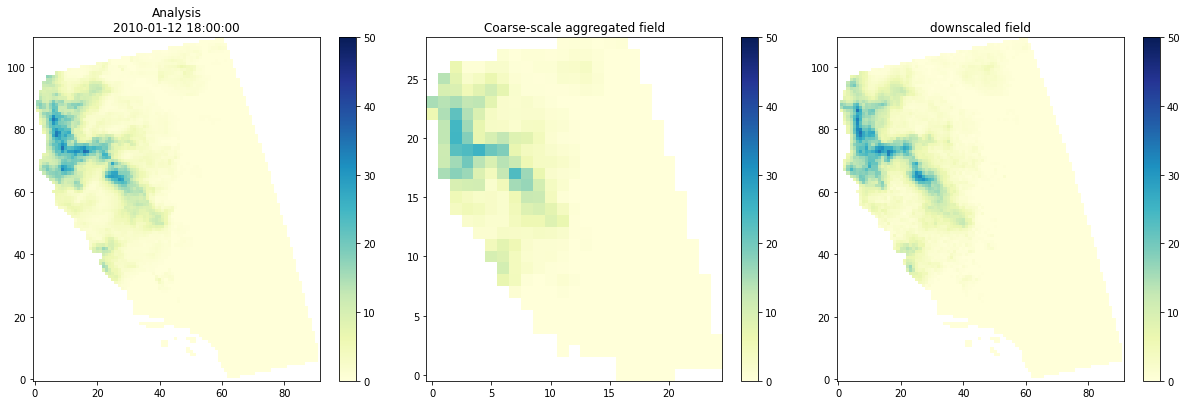

In [48]:
n = 0
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(17,5.4))
ims = ax1.imshow(N_fineFields_lgD[n,:,:], origin='lower', cmap='YlGnBu', vmin=0, vmax=50)
cbar = plt.colorbar(ims, ax=ax1)
ax1.set_title('Analysis\n'+str(date_end6h[n]))
ims = ax2.imshow(N_coarseFields_lgD[n,:,:], origin='lower', cmap='YlGnBu', vmin=0, vmax=50)
cbar = plt.colorbar(ims, ax=ax2)
ax2.set_title('Coarse-scale aggregated field')
ims = ax3.imshow(N_downFields_lgD[n,:,:], origin='lower', cmap='YlGnBu', vmin=0, vmax=50)
cbar = plt.colorbar(ims, ax=ax3)
ax3.set_title('downscaled field')
plt.tight_layout()
plt.show()

And the climatologies over the $N$ dates:

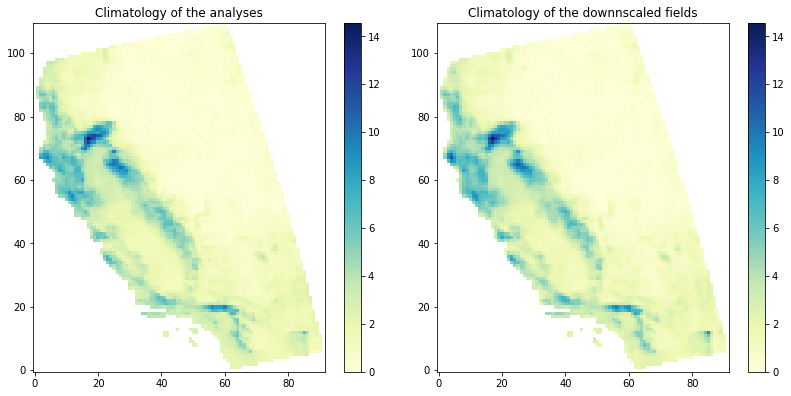

In [352]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11.5,5.4))
vmax = np.max(np.mean(N_fineFields_lgD, axis=0))
ims = ax1.imshow(np.mean(N_fineFields_lgD, axis=0), origin='lower', cmap='YlGnBu', vmin=0, vmax=vmax)
cbar = plt.colorbar(ims, ax=ax1)
ax1.set_title('Climatology of the analyses')
ims = ax2.imshow(np.mean(N_downFields_lgD, axis=0), origin='lower', cmap='YlGnBu', vmin=0, vmax=vmax)
cbar = plt.colorbar(ims, ax=ax2)
ax2.set_title('Climatology of the downnscaled fields')
plt.tight_layout()
plt.show()

## 3.3 Dynamic adaptation of the parameters domains (experimental)

In reality precipitation features most often span over more than one calibration subdomain, and with the array `field_parDomain` calculated as above (i.e., that follows the calibration subdomains), it is inevitable that multiple downscaling configurations (GSDM variant, set of predictors, parameters) be used over a same continuous precipitation feature. Changing downscaling configuration from one coarse-pixel to the next might create a visual discontinuity, if the two downscaling configurations are really different. 

So far, over the area of California, we have found that these discontinuities are either unnoticeable, or largely acceptable.

Nonetheless, we still propose an alternative for computing the aray `field_parDomain`, which dynamically adapts to each coarse-scale precipitation field by proposing subdomains that encompasse the different precipitation features. This is done through the function `parameterSpatialization()`, which takes a dictionnary of tunable parameters `par_paramSpat`:

In [427]:
par_paramSpat = dict(radius_in_pix=0, T=4, buffer=15)

Let's try `parameterSpatialization()` for a given date:

In [361]:
n = 39
coarseFields_lgD = N_coarseFields_lgD[n,:,:]

field_parDomain = parameterSpatialization(coarse_field_lgD=ma.filled(coarseFields_lgD, fill_value=0.), 
                                          lons_fcst_lgD=lon_coarse_lgD, 
                                          lats_fcst_lgD=lat_coarse_lgD, 
                                          Dbounds_area=D_boundsArea, 
                                          par_paramSpat=par_paramSpat, 
                                          mask_coarsefield_lgD=mask_coarse_lgD, 
                                          seed=seed*n)

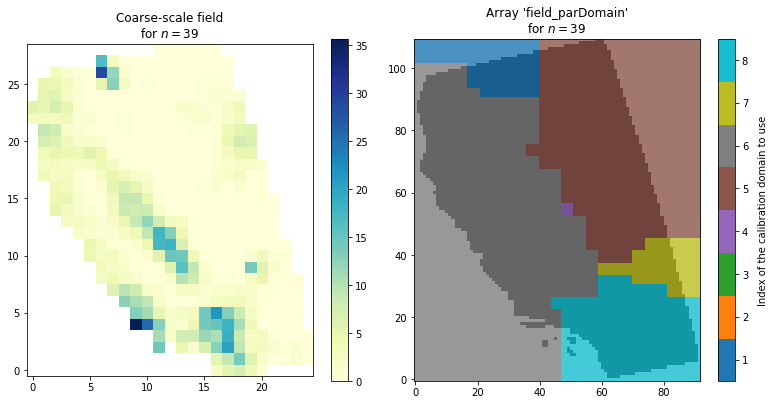

In [362]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11,5.4))
ims = ax1.imshow(coarseFields_lgD, origin='lower', cmap='YlGnBu')
cbar = plt.colorbar(ims, ax=ax1)
ax1.set_title('Coarse-scale field\nfor $n='+str(n)+'$')

field_parDomain_regridded = regrid_coarse2fine(field_parDomain[None,:,:], [lat_fine_lgD,lon_fine_lgD,lat_coarse_lgD,lon_coarse_lgD])[0,:,:]
ims = ax2.imshow(field_parDomain_regridded, origin='lower', cmap=plt.get_cmap('tab10', D), vmax=D)
ax2.imshow(mask_fine_lgD, origin='lower', cmap='Greys_r', alpha=0.2)
cbar = plt.colorbar(ims, ticks=np.arange(0.5,D))
cbar.ax.set_yticklabels(np.arange(1,D+1))
cbar.set_label('Index of the calibration domain to use', labelpad=10)
ax2.set_title("Array 'field_parDomain'\nfor $n="+str(n)+"$")

plt.tight_layout()
plt.show()

In a nutshell, the algorithm embedded in `parameterSpatialization()` identifies precipitation features on the coarse-scale field, and builds boundaries (around these features) that "cross" as little precipitation as possible. Indeed, the idea is to have the boundaries over areas of little or no precipitation, such that when the GSDM switches from one downscaling configuration to another, it doesn't create any visual discontinuity.

The function is algorithmically quite complex, using algorithms such as:
- convolution and thresholding (to identify the rainfall features),
- Delauney triangulation (in between the controids of the rainfall features),
- Dijkstra algorithm (to find the path of least resistance -i.e., that cross as little precipitation as possible- that encompasses the rainfall features),
- flood-fill algorithm (to associate each pixel to a subdomain based on a list of boundaries).

We do not go over the details here, the function `field_parDomain()` being well commented. We just add here a comment about the tunable parameters:
- `T`: Threshold (in mm) that identifies a rainfall feature. 
    - `T` too low (e.g., 0.5 mm): Generates very few (but large) features, which means a lower risk of "cutting" a precipitation area, but higher risk of using non-optimal GSDM parameters,
    - `T` too high (e.g., 10 mm): Generates numerous (but small) features, which means a higher risk of "cutting" a precipitation area, but the GSDM parameters will be more optimal.
- `radius_in_pix`: Radius of the convolution (in number of coarse-scale pixels) that is applied to the coarse-scale before the features are identified.
    - `radius_in_pix` too low (e.g., 0 pix): Very nearby features remain as individual features,
    - `radius_in_pix` too high (e.g., 4 pix): Tends to merge quite distinct rainfall features into a single feature (higher risk of using non-optimal GSDM parameters).
- `buffer`: Distance (in number of coarse-scale pixels) to which we extent the search area around the source and target points, in the Dijkstra's algorithm.
    - `buffer` too low (e.g., 3 pix): Higher risk of "cutting" a precipitation area (especially if it is a large area), but code faster,
    - `buffer` too high (e.g., 15 pix): Lower risk of "cutting" a precipitation area, but code slower.
